## 전기차 정보를 이용한 차량 가격 예측 모델 개발

## CatBoost 모델 학습

In [ ]:
# !pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from catboost import CatBoostRegressor

In [ ]:
# train data 확인
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

In [ ]:
# 테스트 데이터의 제조사와 모델이 학습 데이터에 있는지 확인
missing_manufacturers = set(test_data['제조사']) - set(train_data['제조사'])
missing_models = set(test_data['모델']) - set(train_data['모델'])

# 결과 출력
if missing_manufacturers:
    print("테스트 데이터에 있는 제조사 중 학습 데이터에 없는 제조사:", missing_manufacturers)
else:
    print("모든 테스트 데이터의 제조사가 학습 데이터에 포함되어 있습니다.")

if missing_models:
    print("테스트 데이터에 있는 모델 중 학습 데이터에 없는 모델:", missing_models)
else:
    print("모든 테스트 데이터의 모델이 학습 데이터에 포함되어 있습니다.")

모든 테스트 데이터의 제조사가 학습 데이터에 포함되어 있습니다.
모든 테스트 데이터의 모델이 학습 데이터에 포함되어 있습니다.


In [ ]:
# 타겟 인코딩 함수
def target_encoding_simple(df, target_col, group_col):
    mean_target = df.groupby(group_col)[target_col].mean()
    return df[group_col].map(mean_target)

# 제조사와 모델에 대해 타겟 인코딩
train_data['제조사_타겟인코딩'] = target_encoding_simple(train_data, '가격(백만원)', '제조사')
test_data['제조사_타겟인코딩'] = test_data['제조사'].map(train_data.groupby('제조사')['가격(백만원)'].mean().round(3))

train_data['모델_타겟인코딩'] = target_encoding_simple(train_data, '가격(백만원)', '모델')
test_data['모델_타겟인코딩'] = test_data['모델'].map(train_data.groupby('모델')['가격(백만원)'].mean().round(3))

In [ ]:
# 범주형 변수 인코딩 (간소화)
category_mapping = {
    '차량상태': {'Brand New': 0, 'Nearly New': 1, 'Pre-Owned': 2},
    '구동방식': {'AWD': 0, 'FWD': 1, 'RWD': 2},
    '사고이력': {'No': 0, 'Yes': 1}
}

for col, mapping in category_mapping.items():
    train_data[col] = train_data[col].map(mapping)
    test_data[col] = test_data[col].map(mapping)

# ID 열 제거
train_data = train_data.drop(columns=['ID'], axis=1)

In [ ]:
# !pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 55.5 MB/s eta 0:00:00


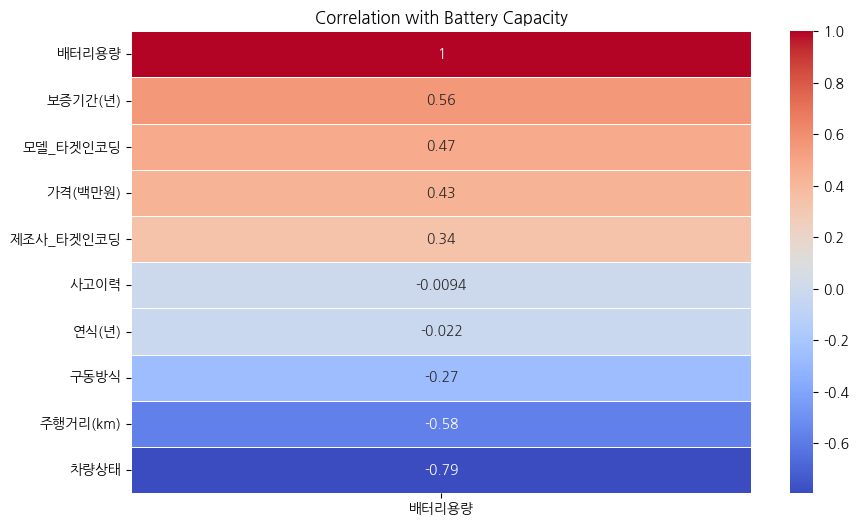

Train data battery capacity missing values filled.
Test data battery capacity missing values filled.


In [ ]:
# 결측치 처리 (배터리 용량)
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# 데이터의 숫자형 변수들만 추출
numerical_df = train_data.select_dtypes(include=['float64', 'int64'])

# 상관관계 계산
correlation_matrix = numerical_df.corr()

# 배터리 용량과 다른 변수와의 상관관계 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['배터리용량']].sort_values(by='배터리용량', ascending=False),
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation with Battery Capacity')
plt.show()

# 결측치가 있는 행과 없는 행으로 데이터 분리
non_missing_data = train_data[train_data['배터리용량'].notna()]
missing_data = train_data[train_data['배터리용량'].isna()]

# 사용할 변수 선택 (상관관계가 높은 변수들)
features_for_imputation = ['보증기간(년)', '모델_타겟인코딩', '제조사_타겟인코딩']

# 학습 데이터 준비
X_train_impute = non_missing_data[features_for_imputation]
y_train_impute = non_missing_data['배터리용량']

# 결측치가 있는 데이터 준비
if not missing_data.empty:
    X_test_impute = missing_data[features_for_imputation]
else:
    print("No missing values in train_data for '배터리용량'.")

# RandomForest 모델 학습 및 예측
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_impute, y_train_impute)

if not missing_data.empty:
    predicted_values = rf_model.predict(X_test_impute)
    train_data.loc[train_data['배터리용량'].isna(), '배터리용량'] = predicted_values
    print("Train data battery capacity missing values filled.")

# 테스트 데이터에서 결측치 처리
test_missing_data = test_data[test_data['배터리용량'].isna()]

if not test_missing_data.empty:
    X_test_missing = test_missing_data[features_for_imputation]
    predicted_test_values = rf_model.predict(X_test_missing)
    test_data.loc[test_data['배터리용량'].isna(), '배터리용량'] = predicted_test_values
    print("Test data battery capacity missing values filled.")


In [ ]:
# 독립 변수(features)와 종속 변수(target) 정의
features = ['차량상태', '배터리용량', '구동방식','주행거리(km)',
            '보증기간(년)','사고이력', '연식(년)', '제조사_타겟인코딩','모델_타겟인코딩']

X = train_data[features]
y = train_data['가격(백만원)']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# CatBoost 모델 생성 및 학습
catboost_model = CatBoostRegressor(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    random_seed=42,
    verbose=0
)
catboost_model.fit(X_train, y_train)

In [ ]:
# 예측
y_pred = catboost_model.predict(X_test)

In [ ]:
# 평가 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")
print(f"MAE: {mae}")

RMSE: 1.4690081635997994
R² Score: 0.9984294116020267
MAE: 0.7620652909375384


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# 테스트 데이터 예측
test_features = test_data[features]
test_predictions = catboost_model.predict(test_features)

# 결과 저장: ID와 가격(백만원) 열만 유지
submission = test_data[['ID']].copy()  # ID 열 복사
submission['가격(백만원)'] = test_predictions  # 가격(백만원) 예측값 추가

# 파일 저장
submission.to_csv('/content/drive/MyDrive/predicted_prices_cat.csv', index=False)
print("Predicted prices saved to 'predicted_prices_cat.csv'")

Predicted prices saved to 'predicted_prices_cat.csv'


In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 후보 정의
param_grid = {
    'iterations': [100, 200, 300],
    'depth': [6, 8, 10],
    'learning_rate': [0.01, 0.05, 0.1]
}

# GridSearchCV 실행
grid_search = GridSearchCV(
    estimator=CatBoostRegressor(random_seed=42, verbose=0),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'depth': 6, 'iterations': 300, 'learning_rate': 0.1}


## Decision Tree 모델 학습

모든 테스트 데이터의 제조사가 학습 데이터에 포함되어 있습니다.
모든 테스트 데이터의 모델이 학습 데이터에 포함되어 있습니다.


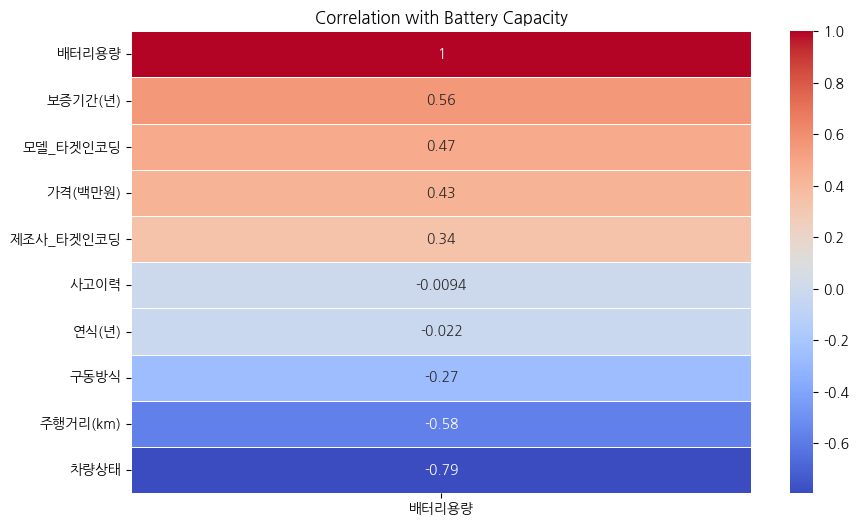

Train data battery capacity missing values filled.
Test data battery capacity missing values filled.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor

# train data 확인
train_data = pd.read_csv('/content/drive/MyDrive/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/test.csv')

# 테스트 데이터의 제조사와 모델이 학습 데이터에 있는지 확인
missing_manufacturers = set(test_data['제조사']) - set(train_data['제조사'])
missing_models = set(test_data['모델']) - set(train_data['모델'])

# 결과 출력
if missing_manufacturers:
    print("테스트 데이터에 있는 제조사 중 학습 데이터에 없는 제조사:", missing_manufacturers)
else:
    print("모든 테스트 데이터의 제조사가 학습 데이터에 포함되어 있습니다.")

if missing_models:
    print("테스트 데이터에 있는 모델 중 학습 데이터에 없는 모델:", missing_models)
else:
    print("모든 테스트 데이터의 모델이 학습 데이터에 포함되어 있습니다.")

# 타겟 인코딩 함수
def target_encoding_simple(df, target_col, group_col):
    mean_target = df.groupby(group_col)[target_col].mean()
    return df[group_col].map(mean_target)

# 제조사와 모델에 대해 타겟 인코딩
train_data['제조사_타겟인코딩'] = target_encoding_simple(train_data, '가격(백만원)', '제조사')
test_data['제조사_타겟인코딩'] = test_data['제조사'].map(train_data.groupby('제조사')['가격(백만원)'].mean().round(3))

train_data['모델_타겟인코딩'] = target_encoding_simple(train_data, '가격(백만원)', '모델')
test_data['모델_타겟인코딩'] = test_data['모델'].map(train_data.groupby('모델')['가격(백만원)'].mean().round(3))

# 범주형 변수 인코딩 (간소화)
category_mapping = {
    '차량상태': {'Brand New': 0, 'Nearly New': 1, 'Pre-Owned': 2},
    '구동방식': {'AWD': 0, 'FWD': 1, 'RWD': 2},
    '사고이력': {'No': 0, 'Yes': 1}
}

for col, mapping in category_mapping.items():
    train_data[col] = train_data[col].map(mapping)
    test_data[col] = test_data[col].map(mapping)

# ID 열 제거
train_data = train_data.drop(columns=['ID'], axis=1)

# !pip install koreanize-matplotlib

# 결측치 처리 (배터리 용량)
import koreanize_matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

# 데이터의 숫자형 변수들만 추출
numerical_df = train_data.select_dtypes(include=['float64', 'int64'])

# 상관관계 계산
correlation_matrix = numerical_df.corr()

# 배터리 용량과 다른 변수와의 상관관계 시각화
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix[['배터리용량']].sort_values(by='배터리용량', ascending=False),
            annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation with Battery Capacity')
plt.show()

# 결측치가 있는 행과 없는 행으로 데이터 분리
non_missing_data = train_data[train_data['배터리용량'].notna()]
missing_data = train_data[train_data['배터리용량'].isna()]

# 사용할 변수 선택 (상관관계가 높은 변수들)
features_for_imputation = ['보증기간(년)', '모델_타겟인코딩', '제조사_타겟인코딩']

# 학습 데이터 준비
X_train_impute = non_missing_data[features_for_imputation]
y_train_impute = non_missing_data['배터리용량']

# 결측치가 있는 데이터 준비
if not missing_data.empty:
    X_test_impute = missing_data[features_for_imputation]
else:
    print("No missing values in train_data for '배터리용량'.")

# RandomForest 모델 학습 및 예측
rf_model = RandomForestRegressor(random_state=42, n_estimators=100)
rf_model.fit(X_train_impute, y_train_impute)

if not missing_data.empty:
    predicted_values = rf_model.predict(X_test_impute)
    train_data.loc[train_data['배터리용량'].isna(), '배터리용량'] = predicted_values
    print("Train data battery capacity missing values filled.")

# 테스트 데이터에서 결측치 처리
test_missing_data = test_data[test_data['배터리용량'].isna()]

if not test_missing_data.empty:
    X_test_missing = test_missing_data[features_for_imputation]
    predicted_test_values = rf_model.predict(X_test_missing)
    test_data.loc[test_data['배터리용량'].isna(), '배터리용량'] = predicted_test_values
    print("Test data battery capacity missing values filled.")

In [ ]:
# 독립 변수(features)와 종속 변수(target) 정의
features = ['차량상태', '배터리용량', '구동방식','주행거리(km)',
            '보증기간(년)','사고이력', '연식(년)', '제조사_타겟인코딩','모델_타겟인코딩']

X = train_data[features]
y = train_data['가격(백만원)']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Decision Tree 모델 생성 및 학습
dt_model = DecisionTreeRegressor(
    max_depth=8,
    min_samples_leaf=2,
    min_samples_split=10,
    random_state=42
)
dt_model.fit(X_train, y_train)

# 예측
y_pred = dt_model.predict(X_test)

In [ ]:
# 평가 지표 계산
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")
print(f"MAE: {mae}")

RMSE: 1.50865130111366
R² Score: 0.9983434989719939
MAE: 0.7668668285933965


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# 테스트 데이터 예측
test_features = test_data[features]
test_predictions = dt_model.predict(test_features)

# 결과 저장: ID와 가격(백만원) 열만 유지
submission = test_data[['ID']].copy()  # ID 열 복사
submission['가격(백만원)'] = test_predictions  # 가격(백만원) 예측값 추가

# 파일 저장
submission.to_csv('/content/drive/MyDrive/predicted_prices_dt.csv', index=False)
print("Predicted prices saved to 'predicted_prices_dt.csv'")

Predicted prices saved to 'predicted_prices_dt.csv'


In [ ]:
# 하이퍼파라미터 튜닝
from sklearn.model_selection import GridSearchCV

# 하이퍼파라미터 후보 정의
param_grid = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# GridSearchCV 실행
grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5
)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10}
